In [2]:
import random
import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from collections import Counter
from math import sqrt
from scipy.stats import binom

# organism class
organism that stores its own genome, evaluates its own fitness, and produces offspring with mutations and crossover if a second parent is given


In [3]:
class Org:
    def __init__(self,genomeLength,evalFunction,mutationRate):
        self.genome = [0 for _ in range(genomeLength)]
        self.offspringCount = 0
        self._fitness = None
        self.evalFunction = evalFunction
        self.mutationRate = mutationRate
        self.genomeLength = genomeLength
        self.cladeID = None
        
    def fitness(self,):
        if self._fitness is None:
            self._fitness = self.evalFunction(self)
        return self._fitness
    
    def makeMutatedOffspring(self,*otherParents):
        newOrganism = Org(self.genomeLength,self.evalFunction,self.mutationRate)

        if otherParents:
            cuts = sorted([random.randint(0,self.genomeLength-1) for _ in range(len(otherParents))])
            newOrganism.genome = self.genome[0:cuts[0]]
            for c in range(len(cuts)-1):
                newOrganism.genome.extend(otherParents[c-1].genome[cuts[c]:cuts[c+1]])
            newOrganism.genome.extend(otherParents[-1].genome[cuts[-1]:])
            newOrganism.cladeID = [self.cladeID]+[parent.cladeID for parent in otherParents]
        else:
            newOrganism.genome = copy.deepcopy(self.genome)
            newOrganism.cladeID = self.cladeID
            
        for site in range(self.genomeLength):
            if random.random() <= self.mutationRate:
                newOrganism.genome[site] += random.randint(0,1)*2 -1
        
        self.offspringCount += 1
        for p in range(len(otherParents)):
            otherParents[p].offspringCount += 1
            
        return newOrganism

#UNIT TEST
o1 = Org(10,lambda x: sum(x.genome),0.2)
o2 = o1.makeMutatedOffspring()
o3 = o2.makeMutatedOffspring()
o4 = o3.makeMutatedOffspring(o1,o2)

print(o1.offspringCount)
print(o2.offspringCount)
print(o3.offspringCount)
print(o4.offspringCount)

print(o1.genome)
print(o2.genome)
print(o3.genome)
print(o4.genome)

2
2
1
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, -1, 1, 0, 0, -1, 0, -1, 0, 1]
[0, -1, 1, 0, 0, -1, 0, -1, 0, 1]
[0, -1, 1, 0, 0, -1, 0, -1, -1, 0]


# fitness functions
- sum of genome values
- const value (for neutral drift)
- abc function assigns fitness to one of 3 alleles otherwises errors.

In [4]:
def eval_sumOfGenome(org):
    return sum(org.genome)

def eval_constValue(org):
    return 1

def eval_ABC(org):
    if org.genome[0] == 0:
        return 1
    if org.genome[0] == 1:
        return 1.1
    if org.genome[0] == 2:
        return 1.2
    print("ERROR",org.genome[0])

# selection algorithms
- tournament, with batch size 
- roulette, with exponent parameter

In [5]:
def tournament(population,batchSize,size):
    return [max(random.choices(list(range(len(population))), k=size),
                                    key= lambda ID: population[ID].fitness()) for _ in range(batchSize)]

def roulette(population,batchSize,exponent):
    MAX = max([org.fitness() for org in population])
    F = [np.power(exponent,org.fitness()-MAX) for org in population]
    S = sum(F)
    return random.choices(list(range(len(population))),k=batchSize,weights=[f/S for f in F])

# reproduction model class
this class allows me to pass a single object that can execute several reproduction models. 

In [6]:
class ReproductionModel:
    def __init__(self,modelName,selectionFunction,parents,strength):
        self.modelName = modelName
        self.selectionFunction = selectionFunction
        self.parents = parents
        self.strength = strength
        self.warn_moransex = False
    
    def _wright_fisher(self,population,_):
        ps = len(population)
        selectionIDs = self.selectionFunction(population,ps*self.parents,self.strength)  
        return [population[selectionIDs[p]]
                .makeMutatedOffspring(*[population[selectionIDs[p + ps*(o+1)]] for o in range(self.parents-1)])
                for p in range(ps)]
    
    def _moran(self,population,_):
        if self.parents > 1 and not self.warn_moransex: 
            print("WARNING: moran with sex has no drift reference (yet).")
            self.warn_moransex = True
        birthIDs = self.selectionFunction(population,self.parents,self.strength)
        deathID = random.randint(0,len(population)-1)
        
        child = population[birthIDs[0]].makeMutatedOffspring(*[population[bid] for bid in birthIDs[1:]])
        population[deathID] = child
        return copy.deepcopy(population)
    
    def _getKernel(self,i,j,pop_2d,d=1):
        grid_width = len(pop_2d)
        kernel = []
        for ioff in range(-d,d+1):
            for joff in range(-d,d+1):
                kernel.append(pop_2d[(i+ioff)%grid_width][(j+joff)%grid_width])
        return kernel
    
    def _deserialize(self,pop1d):
        pop_len = int(np.sqrt(len(pop1d)))
        return [[pop1d[j+(i*pop_len)] for j in range(pop_len)] for i in range(pop_len)]


    def _serialize(self,pop2d):
        return list(itertools.chain.from_iterable(pop2d))
    
    def _spatial(self,population,kernelSize):
        pop_len = int(np.sqrt(len(population)))
        if pop_len**2 != len(population):print("WARNING: populaiton size is not a perfect square!")
            
        pop_2D = self._deserialize(population)
        new_pop_2D = [[None for j in range(pop_len)] for i in range(pop_len)]

        for i in range(pop_len):
            for j in range(pop_len):
                kernel = self._getKernel(i,j,pop_2D,kernelSize)
                birthIDs = self.selectionFunction(kernel,self.parents,self.strength)

                new_pop_2D[i][j] = kernel[birthIDs[0]].makeMutatedOffspring(
                    *[population[bid] for bid in birthIDs[1:]])
        return self._serialize(new_pop_2D)
    
    def getNextPop(self,population,kernelSize):
        if self.modelName == "WF":
            return self._wright_fisher(population,kernelSize)
        if self.modelName == "M":
            return self._moran(population, kernelSize)
        if self.modelName == "S":
            return self._spatial(population,kernelSize)
        print("ERROR: bad model name")
        return None

    
## UNIT TESTS
p0 = [Org(10,eval_sumOfGenome,0.2) for _ in range(16)]
for i in range(16):
    p0[i].cladeID = i
par = 1
m0 = ReproductionModel("S",roulette,par,1.05)
p1 = m0.getNextPop(p0,1)
p2 = m0.getNextPop(p1,1)
p3 = m0.getNextPop(p2,1)
print(sum([org.offspringCount for org in p0]))
print(sum([org.offspringCount for org in p1]))
print(sum([org.offspringCount for org in p2]))
print(sum([org.offspringCount for org in p3]))
print("----")
for p in p3:
    print(p.cladeID)

16
16
16
0
----
0
9
2
1
14
8
2
4
4
13
1
4
8
1
4
9


# Selection impact metrics for Wright-Fisher and Moran models, and their helper functions
WF model uses a single function "getDriftReference" while Moran model uses several, "moranTPM" and "moranDriftReference"

In [7]:
def dictionaryReduce(listOfDict,target={}):
    #NOTE: if the target and listOfDict both lack a key,
    #      the updated target will not contain an entry for that key:
    #      this function aims to include zeros for missing keys
    #      therefore, some entries may lack zeros if they are not 
    #      represented in the initial set of keys provided; this function is
    #      best used when listOfDict is the final set of dics to be reduced
    maxKey = max([max([k for k in d.keys()]+[-1]) for d in listOfDict]+[max(list(target.keys())+[-1])])
    for dic in listOfDict:
        for key in range(maxKey+1):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target


def getAveDistFromLog(log,popSize):
    totalCounts = {}
    dictionaryReduce([Counter(entry) for entry in log],totalCounts)
    means = [(key, mean(totalCounts[key])/popSize) for key in sorted(totalCounts)]
    stdevs = [(key, stdev(totalCounts[key])/popSize) if len(totalCounts[key])>1 else (key,0) for key in sorted(totalCounts)]
    return means, stdevs


DR = {}
def getDriftReference(initialPop,finalPop,parents): #wright-fisher
    global DR
    key = (initialPop,finalPop,parents)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop*parents, 1/initialPop) for x in range(finalPop*parents+1)]
    return DR[key]


def getSigThreshold(DR,p=0.05):
    probVal = 1.0
    index_i = 0
    while probVal > p:
        probVal -= DR[index_i]
        index_i += 1
    return index_i

TPM_MEMO = {}
def moranTPM(Ni,Nf):
    global TPM_MEMO
    key = (Ni,Nf)
    if key not in TPM_MEMO:
        TPM = []
        if Ni == Nf:
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Ni+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append((1-(row/Ni))*(row/Ni))
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append((row/Ni)**2 + (1-(row/Ni))**2)
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append((row/Ni)*(1-(row/Ni)))
                    else:
                        TPM[row].append(0.0)
        elif Ni+1 == Nf:
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni))
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append(row/Ni)
                    else:
                        TPM[row].append(0.0)
        elif Ni-1 == Nf:
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append(row/Ni)
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni))
                    else:
                        TPM[row].append(0.0)
        else:
            print("ERROR: Invalid population sizes in moran drift reference.")
            return None
        TPM_MEMO[key] = TPM
    else:
        TPM = TPM_MEMO[key]
         
    return TPM

def moranDriftReference(popSizeHistory): #moran
    Xnp = np.array([0.,1.]+[0. for _ in range(popSizeHistory[0]-1)])
    for Ni,Nf in zip(popSizeHistory[:-1],popSizeHistory[1:]):
        TPMnp = np.array(moranTPM(Ni,Nf))
        Xnp = np.dot(Xnp,TPMnp)
    return Xnp

## UNIT TEST
print(moranDriftReference([3 for _ in range(100)]))
print(moranDriftReference([3 if i%2==0 else 4 for i in range(100)]))
print(moranDriftReference([3,2,3,4,5,6,5,4,3]))

[6.66666667e-01 7.82830127e-12 7.82830127e-12 3.33333333e-01]
[6.66600736e-01 4.39539276e-05 4.39539276e-05 4.39539276e-05
 3.33267402e-01]
[0.43333333 0.23333333 0.23333333 0.1       ]


# full parameter sweep
this code will run many combinations of various peramaters. 

In [8]:
POPSIZE = [100]
MUTRATE = [1/8]
GENOMSZ = [1]
EVALFUN = [eval_constValue]
NUMGENS = [50000]
SLCTALG = [roulette]
PARENTS = [1,2]
SELSTRN = [2.]
KERNSIZ = [1]
MODELNM = ["WF","M"]

globalLog = []

for kernsiz in KERNSIZ:
    for mutrate in MUTRATE:
        for evalfun in EVALFUN:
            for genomsz in GENOMSZ:
                for slctalg in SLCTALG:
                    for parents in PARENTS:
                        for selstrn in SELSTRN:
                            for modelnm in MODELNM:
                                thisModel = ReproductionModel(modelnm,slctalg,parents,selstrn)

                                for popsize in POPSIZE:
                                    thisPopulation = [Org(genomsz,evalfun,mutrate) for _ in range(popsize)]
                                    ## special genome init for ABC test
                                    for i in range(popsize):
                                        thisPopulation[i].genome[0] = i // (popsize//3)
#                                         print(i // (popsize//3))
                                    ##
                                    
                                    for i in range(popsize):
                                        thisPopulation[i].cladeID = i
                                    for numgens in NUMGENS:
                                        config = {"kernelSize":kernsiz, "mutationRate":mutrate, "evalFunction":evalfun,
                                                 "genomeSize":genomsz, "selectionAlgorithm":slctalg, "numParents":parents,
                                                 "selectionStrength":selstrn, "popSize":popsize, "numGenerations":numgens,
                                                 "populationModel":modelnm}
                                        print("Running: popSize:{} mu:{} parents:{} kernel:{}".format(
                                            popsize,mutrate,parents,kernsiz))
                                        offCountLog = []
                                        cladeLog = []
                                        fitnessLog = []
                                        genomeLog = []
                                        popsizeLog = []
                                        for generation in range(numgens):
                                            if generation%popsize == 0:
                                                cladeLog.append([org.cladeID for org in thisPopulation])
                                                genomeLog.append([org.genome for org in thisPopulation])
                                                for i in range(popsize):
                                                    thisPopulation[i].cladeID = i
                                            nextPopulation = thisModel.getNextPop(thisPopulation,kernsiz)
                                            offCountLog.append([org.offspringCount for org in thisPopulation])
                                            fitnessLog.append(mean([org.fitness() for org in thisPopulation]))
#                                             genomeLog.append([org.genome for org in thisPopulation])
                                            popsizeLog.append(len(thisPopulation))
                                            thisPopulation = nextPopulation
                                        globalLog.append({"popsizelog":popsizeLog,"fitness":fitnessLog,"genome":genomeLog,"offCounts":offCountLog,"cladeIDs":cladeLog,"config":config})

print("DONE")

Running: popSize:100 mu:0.125 parents:1 kernel:1


Running: popSize:100 mu:0.125 parents:1 kernel:1
Running: popSize:100 mu:0.125 parents:2 kernel:1
Running: popSize:100 mu:0.125 parents:2 kernel:1
DONE


# publication figure for drift model verification
this pannel uses the data generated above to create the figure seen in the publication. 

<>:32: SyntaxWarning: invalid escape sequence '\h'
<>:68: SyntaxWarning: invalid escape sequence '\h'
<>:32: SyntaxWarning: invalid escape sequence '\h'
<>:68: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_16528/2801374854.py:32: SyntaxWarning: invalid escape sequence '\h'
  axs[condIndex].scatter(X,Y,label="$\hat f(n)$",color="r")
/tmp/ipykernel_16528/2801374854.py:68: SyntaxWarning: invalid escape sequence '\h'
  axs[condIndex].scatter(X,Y,label="$\hat f(n)$",color="r")


{'kernelSize': 1, 'mutationRate': 0.125, 'evalFunction': <function eval_constValue at 0x7d39a4ec6200>, 'genomeSize': 1, 'selectionAlgorithm': <function roulette at 0x7d398ec7c2c0>, 'numParents': 1, 'selectionStrength': 2.0, 'popSize': 100, 'numGenerations': 50000, 'populationModel': 'WF'} 

WF 1
{'kernelSize': 1, 'mutationRate': 0.125, 'evalFunction': <function eval_constValue at 0x7d39a4ec6200>, 'genomeSize': 1, 'selectionAlgorithm': <function roulette at 0x7d398ec7c2c0>, 'numParents': 1, 'selectionStrength': 2.0, 'popSize': 100, 'numGenerations': 50000, 'populationModel': 'M'} 

{'kernelSize': 1, 'mutationRate': 0.125, 'evalFunction': <function eval_constValue at 0x7d39a4ec6200>, 'genomeSize': 1, 'selectionAlgorithm': <function roulette at 0x7d398ec7c2c0>, 'numParents': 2, 'selectionStrength': 2.0, 'popSize': 100, 'numGenerations': 50000, 'populationModel': 'WF'} 

WF 2


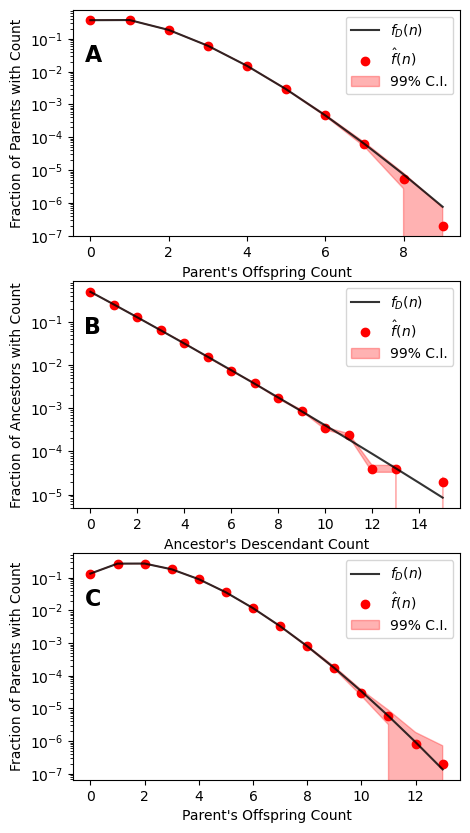

In [9]:
#globalLog: each condition in order
#expLog: offCounts, CladeIDs

pannelLabels = ["A","B","C"]
labelX = 0.03
labelY = 0.85
numConditions = len(globalLog[:3])
fig, axs = plt.subplots(numConditions,figsize=(5,10))

for condIndex, expLog in enumerate(globalLog[:3]):
    print(expLog["config"],"\n")
#     plt.plot(expLog["fitness"])
#     plt.show()
    
    if expLog["config"]["populationModel"] == "WF":
        GENS = expLog["config"]["numGenerations"]
        POPS = expLog["config"]["popSize"]
        PAR = expLog["config"]["numParents"]
        print("WF",PAR)
        means,stdevs = getAveDistFromLog(expLog["offCounts"],POPS)
        X,Y = list(zip(*means))
        _,S = list(zip(*stdevs))

#         plt.figure(figsize=(10,5))
        axs[condIndex].plot(getDriftReference(POPS,POPS,PAR)[:max(X)+1],
                 label="$f_D(n)$",color="k",alpha=0.8)

    #     sigthresh = getSigThreshold(getDriftReference(POPS,POPS),p=0.01)
    #     print("Larger than",sigthresh,
    #           "offspring is signifigantly more than expected by drift.")
    #     plt.axvline(sigthresh)
        axs[condIndex].scatter(X,Y,label="$\hat f(n)$",color="r")

        axs[condIndex].fill_between(X,
                         [Y[k]+(2.58*S[k])/sqrt(GENS) for k in X],
                         [Y[k]-(2.58*S[k])/sqrt(GENS) for k in X],
                         alpha=0.3,color="r",label="99% C.I.")
        axs[condIndex].legend()
#         plt.title("")
        axs[condIndex].set_xlabel("Parent's Offspring Count")
        axs[condIndex].set_ylabel("Fraction of Parents with Count")
        axs[condIndex].set_yscale("log")
        axs[condIndex].text(labelX, labelY, pannelLabels[condIndex], transform=axs[condIndex].transAxes, fontsize=16,
                            fontweight='bold', va='top')
#         plt.show()
    
    ###################
    if expLog["config"]["populationModel"] == "M":
        N = expLog["config"]["popSize"]
        G = expLog["config"]["numGenerations"]
        ancesterLog = []
        for entry in expLog["cladeIDs"]:
            ancesterIDCounts = Counter(entry)
            descendentCounts = Counter(ancesterIDCounts.values())
            descendentCounts[0] = N-sum(descendentCounts.values())
            pseudoEntry = []
            for d,a in descendentCounts.items():
                for _ in range(a):
                    pseudoEntry.append(d)
            ancesterLog.append(pseudoEntry)
        means,stdevs = getAveDistFromLog(ancesterLog,N)
        X,Y = list(zip(*means))
        _,S = list(zip(*stdevs))
        
#         plt.figure(figsize=(10,5))
        axs[condIndex].plot(moranDriftReference([N for _ in range(N)])[:max(X)+1],
                 label="$f_D(n)$",color="k",alpha=0.8)
        axs[condIndex].scatter(X,Y,label="$\hat f(n)$",color="r")

        axs[condIndex].fill_between(X,
                         [Y[k]+(2.58*S[k])/sqrt(G) for k in X],
                         [Y[k]-(2.58*S[k])/sqrt(G) for k in X],
                         alpha=0.3,color="r",label="99% C.I.")
        axs[condIndex].legend()
#         plt.title("")
        axs[condIndex].set_xlabel("Ancestor's Descendant Count")
        axs[condIndex].set_ylabel("Fraction of Ancestors with Count")
        axs[condIndex].set_yscale("log")
        axs[condIndex].text(labelX, labelY, pannelLabels[condIndex], transform=axs[condIndex].transAxes, fontsize=16,
                            fontweight='bold', va='top')
#         plt.show()


    if expLog["config"]["populationModel"] == "S":
        GENS = expLog["config"]["numGenerations"]
        POPS = expLog["config"]["popSize"]
        K = expLog["config"]["kernelSize"]
        Karea = (2*K+1)**2
        means,stdevs = getAveDistFromLog(expLog["offCounts"],POPS)
        X,Y = list(zip(*means))
        _,S = list(zip(*stdevs))

        plt.figure(figsize=(10,5))
        plt.plot(getDriftReference(Karea,Karea)[:max(X)+1],
                 label="Wright-Fisher (spatial) Drift Theory",color="k")

    #     sigthresh = getSigThreshold(getDriftReference(POPS,POPS),p=0.01)
    #     print("Larger than",sigthresh,
    #           "offspring is signifigantly more than expected by drift.")
    #     plt.axvline(sigthresh)
        plt.scatter(X,Y,label="(Mean Count)/(Pop. Size)",color="r")

        plt.fill_between(X,
                         [Y[k]+(2.58*S[k])/sqrt(GENS) for k in X],
                         [Y[k]-(2.58*S[k])/sqrt(GENS) for k in X],
                         alpha=0.3,color="r",label="99% Confidence interval")
        plt.legend()
        plt.title("")
        plt.xlabel("Parent's Offspring Count")
        plt.ylabel("Fraction of Parents with Count")
        plt.yscale("log")
        plt.show()
        
    if expLog["config"]["evalFunction"]==eval_ABC:
        N = expLog["config"]["popSize"]
        G = expLog["config"]["numGenerations"]
        PSL = expLog["popsizelog"]
        print(G//N,"gens")
        for genomeValue in range(2):
            ancesterLog = []
            for eNum in range(G//N):
                fromThis = list(zip(expLog["cladeIDs"][eNum],expLog["genome"][eNum]))
                ingroup = [0,1] if genomeValue == 0 else [2]
#                 print(ingroup)
                group = [cladeID for cladeID, genome in fromThis if genome[0] in ingroup]
#                 print("GROUP",group)
                ancesterIDCounts = Counter(group)
#                 print(ancesterIDCounts)
                descendentCounts = Counter(ancesterIDCounts.values())    
                descendentCounts[0] = len(group)-sum(descendentCounts.values())
#                 print(descendentCounts)
                pseudoEntry = []
                for d,a in descendentCounts.items():
                    for _ in range(a):
                        pseudoEntry.append(d)
                ancesterLog.append(pseudoEntry)
#             print(ancesterLog)    
            means,stdevs = getAveDistFromLog(ancesterLog,len(group))
            X,Y = list(zip(*means))
            _,S = list(zip(*stdevs))

            plt.figure(figsize=(10,5))
            refLog = []
            for xxx in range(G//N):
                refLog.append(moranDriftReference(PSL[xxx*N:N*(xxx+1)]))
            finalRef = [mean(col) for col in zip(*refLog)]
            plt.plot(finalRef[:max(X)+1],
                     label="Moran Drift Theory",color="k")
            plt.scatter(X,Y,label="(Mean Count)/(Pop. Size)",color="r")

            plt.fill_between(X,
                             [Y[k]+(2.58*S[k])/sqrt(G) for k in X],
                             [Y[k]-(2.58*S[k])/sqrt(G) for k in X],
                             alpha=0.3,color="r",label="99% Confidence interval")
            plt.legend()
            plt.title("")
            plt.xlabel("Ancestor's Descendant Count")
            plt.ylabel("Fraction of Ancestors with Count")
            plt.yscale("log")
            plt.show()
plt.savefig("DriftVerifyStacked.pdf", bbox_inches='tight')
plt.show()